In [1]:
 pip install -Uq langgraph langsmith langchain_groq langchain_tavily grandalf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.2/386.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 14.3 MB/s eta 0:00:00


In [3]:
from os import environ
from google.colab import userdata

environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

environ["LANGCHAIN_TRACING_V2"] = "true"
environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
environ["LANGCHAIN_PROJECT"] = "05-LangGraph-Streaming-Outputs"

In [2]:
# 상태 정의
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
  messages: Annotated[list, add_messages]

In [6]:
# 도구 정의
from langchain_tavily import TavilySearch

search = TavilySearch(max_results=3)
tools = [search]


In [5]:
# llm 정의
from langchain_groq import ChatGroq

llm = ChatGroq(model_name="openai/gpt-oss-20b")

llm_with_tools = llm.bind_tools(tools)

In [7]:
# chatnode 정의
def chatbot(state: State) -> State:
  answer = llm_with_tools.invoke(state["messages"])
  return {"messages": [answer]}

In [9]:
# tool node 정의
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools)

In [10]:
# 체크포인터 메모리
from langgraph.checkpoint.memory import MemorySaver

memory_saver = MemorySaver()

In [16]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile(checkpointer=memory_saver)

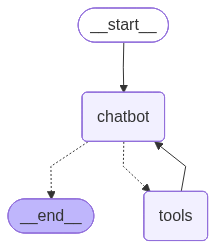

In [17]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [53]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "2"},
)

In [54]:
input = {"messages": [("user", "인터넷에서 에이전트를 검색해주세요.")]}

for event in graph.stream(input, config=config, interrupt_before=["tools"]):
  for key, value in event.items():
    print(f"\n[{key}]\n")
    if "messages" in value:
      value["messages"][-1].pretty_print()
    else:
      print(value)


[chatbot]

================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_99885376-a351-4b79-a4ff-39911148d798)
 Call ID: fc_99885376-a351-4b79-a4ff-39911148d798
  Args:
    query: 에이전트
    search_depth: advanced

[__interrupt__]

()


In [55]:
#  스냅샷 생성
snapshot = graph.get_state(config)

# 넥스트
snapshot.next

('tools',)

In [61]:
# 재개하기
for event in graph.stream(None, config=config):
  for key, value in event.items():
    print(f"\n[{key}]\n")
    if "messages" in value:
      value["messages"][-1].pretty_print();
    else:
      print(value)


[tools]

================================= Tool Message =================================
Name: tavily_search

{"query": "에이전트", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.helpdesk.com/blog/glossary/agent/", "title": "What is Agent? | Definition - HelpDesk", "content": ":   An Agent is a professional dedicated to assisting customers by addressing their needs, answering inquiries, and resolving issues. Agents play a key role in delivering excellent customer service, acting as the first point of contact between a company and its customers. They can provide personalized support, build strong relationships, and ensure customer satisfaction. While 'agent' can also refer to automated systems in specific contexts, it primarily represents the human touch that enhances", "score": 0.7190094, "raw_content": null}, {"url": "https://cloud.google.com/discover/what-are-ai-agents?hl=ko", "title": "AI 에이전트란 무엇인가요? 정의, 예시, 유형 - Google Cloud", "content": 

In [62]:
# 상태 기록 가져오기
for state in graph.get_state_history(config):
  print(state)
  print("next", state.next)
  print("")

StateSnapshot(values={'messages': [HumanMessage(content='인터넷에서 에이전트를 검색해주세요.', additional_kwargs={}, response_metadata={}, id='a295d0bd-1f83-47d0-9579-d8df2b327162'), AIMessage(content='', additional_kwargs={'reasoning_content': 'The user says: "인터넷에서 에이전트를 검색해주세요." Korean: "Please search the internet for \'에이전트\'." They want a search. We need to use tavily_search to get search results. The query is likely "에이전트" but maybe they want general info. We\'ll do a search. Probably "에이전트" meaning "agent" in Korean. Use tavily_search. Use default parameters.', 'tool_calls': [{'id': 'fc_99885376-a351-4b79-a4ff-39911148d798', 'function': {'arguments': '{"query":"에이전트","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 126, 'prompt_tokens': 1366, 'total_tokens': 1492, 'completion_time': 0.11152189, 'prompt_time': 0.125284396, 'queue_time': 0.038247058, 'total_time': 0.236806286}, 'model_name': 'openai/gpt-oss-20b',

In [68]:
# 특정 상태를 저장
to_replay = None
for state in graph.get_state_history(config):
  if len(state.values["messages"]) == 3:
    to_replay = state

print(to_replay)
print(to_replay.config)
print(to_replay.next)

StateSnapshot(values={'messages': [HumanMessage(content='인터넷에서 에이전트를 검색해주세요.', additional_kwargs={}, response_metadata={}, id='a295d0bd-1f83-47d0-9579-d8df2b327162'), AIMessage(content='', additional_kwargs={'reasoning_content': 'The user says: "인터넷에서 에이전트를 검색해주세요." Korean: "Please search the internet for \'에이전트\'." They want a search. We need to use tavily_search to get search results. The query is likely "에이전트" but maybe they want general info. We\'ll do a search. Probably "에이전트" meaning "agent" in Korean. Use tavily_search. Use default parameters.', 'tool_calls': [{'id': 'fc_99885376-a351-4b79-a4ff-39911148d798', 'function': {'arguments': '{"query":"에이전트","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 126, 'prompt_tokens': 1366, 'total_tokens': 1492, 'completion_time': 0.11152189, 'prompt_time': 0.125284396, 'queue_time': 0.038247058, 'total_time': 0.236806286}, 'model_name': 'openai/gpt-oss-20b',

In [70]:
# 특정 체크포인트에서 다시 시작하기
for event in graph.stream(None, to_replay.config, stream_mode="updates"):
  for key, value in event.items():
    print(f"\n[{key}]\n")
    if "messages" in value:
      value["messages"][-1].pretty_print();
    else:
      print(value)


[chatbot]

================================== Ai Message ==================================

**인터넷에서 “에이전트”를 검색한 결과 요약 (2025년 9월 기준)**  

| # | 출처 | 핵심 내용 | URL |
|---|------|-----------|-----|
| 1 | **Google Cloud – AI 에이전트란 무엇인가요?** | AI 에이전트는 LLM(대규모 언어 모델)을 기반으로 하여 도구, 모델, 메모리, 캐릭터 등 여러 구성요소를 조합해 환경과 상호작용하고 복잡한 태스크를 수행하는 시스템이다. 도구를 통해 외부 API와 연결해 데이터를 조작하거나, 사용자 인터페이스(음성, 텍스트, 그래픽 등)를 통해 사람과 소통한다. | <https://cloud.google.com/discover/what-are-ai-agents?hl=ko> |
| 2 | **HelpDesk – What is Agent?** | 일반적으로 ‘에이전트’는 고객 지원을 담당하는 사람(또는 자동화된 시스템)으로, 고객 문의를 받고 문제를 해결하는 역할을 한다. 첫 번째 접점이 되는 인물로서 고객 만족도를 높이는 핵심 인력이다. | <https://www.helpdesk.com/blog/glossary/agent/> |
| 3 | **Dictionary.com – Agent** | 영어 단어 ‘agent’의 정의를 나열. 대표적으로 “다른 사람을 대신해 행동하도록 권한을 부여받은 사람”, “다른 사람을 대신해 일하는 대표자”, “특정 행동을 수행할 수 있는 물리적·비물리적 힘” 등을 포함한다. | <https://www.dictionary.com/browse/agent> |

---

### 주요 키워드와 개념

| 구분 | 키워드 | 설명 |
|------|--------|------|
| **AI 에이전트** | 도구, 모델, 메모리, 캐릭터, 추론 | LLM이 뇌 역할을 하고, 도구를 통해 외